In [2]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), '..')))
import flares


import numpy as np
import matplotlib.cm as cm
import cmasher as cmr
from matplotlib.colors import Normalize
from scipy.stats import binned_statistic

from flares_utility.stats import weighted_median, binned_weighted_quantile
import matplotlib.pyplot as plt

# set style
plt.style.use('../matplotlibrc.txt')


['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39']
['005_z010p000', '006_z009p000', '007_z008p000', '008_z007p000', '009_z006p000', '010_z005p000']
Galaxy
Galaxy/details
Galaxy/details/blackhole_accretion_rate
Galaxy/details/blackhole_accretion_rate/10
Galaxy/details/blackhole_accretion_rate/100
Galaxy/details/blackhole_accretion_rate/20
Galaxy/details/blackhole_accretion_rate/200
Galaxy/details/blackhole_accretion_rate/50
Galaxy/details/blackhole_accretion_rate/instant
Galaxy/details/blackhole_mass
Galaxy/master
Galaxy/master/attenuated_stellar_halpha_ew
Galaxy/master/attenuated_stellar_halpha_luminosity
Galaxy/master/blackhole_accretion_rate
Galaxy/master/blackhole_accretion_rate/instant
Galaxy/master/blackhole_id
Galaxy/master/blackhole_mass
Galaxy/master/intrinsic_stellar_halpha_ew
Galaxy/master

In [3]:


tag = flares.tags[-1]
print(tag)
quantities = flares.get_quantities(tag, group='details')

blackhole_mass = quantities['blackhole_masses'].to('Msun')
blackhole_accretion_rate = quantities['accretion_rates']['10'].to('Msun/yr')
bolometric_luminosity = quantities['bolometric_luminosities']['10']
eddington_ratio = quantities['eddington_ratios']['10']
weights = quantities['weights']

print(np.max(eddington_ratio))

print(np.log10(np.max(blackhole_mass)))
print(np.log10(np.max(eddington_ratio)))
print(np.max(eddington_ratio[eddington_ratio>0.]))
print(np.min(blackhole_accretion_rate), np.max(blackhole_accretion_rate))

conservative_selection = (blackhole_mass.to('Msun').value>1E7) & (bolometric_luminosity.to('erg/s').value>1E45)

print(np.sum(conservative_selection))


010_z005p000
nan dimensionless
9.164834591143547
nan
3.1299120353631844 dimensionless
-16.944017725258494 Msun/yr 13.593134627052214 Msun/yr
153


/Users/sw376/Dropbox/Research/projects/flares_agn_ionising/venv/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


## $M_{\bullet}$ vs. $\lambda_{\rm Edd}$

/Users/sw376/Dropbox/Research/projects/flares_agn_ionising/venv/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/Users/sw376/Dropbox/Research/projects/flares_agn_ionising/venv/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_65882/1382810691.py:54: RuntimeWarning: divide by zero encountered in log10
  s2 = np.log10(blackhole_mass.to('Msun').value) > 7


figures/black_hole_mass-eddington.pdf


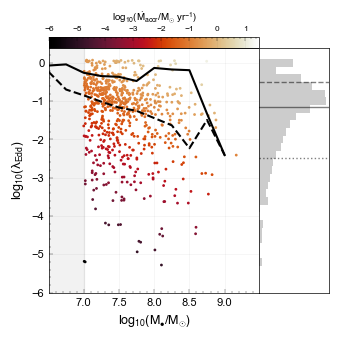

In [4]:


xlimits = Mbh_limit = [6.51, 9.49] # Msun
ylimits = np.array([-6., 0.4])

fig = plt.figure(figsize = (3.5, 3.5))

left  = 0.15
height = 0.7
bottom = 0.15
width = 0.6
hwidth = 0.2

ax = fig.add_axes((left, bottom, width, height))
cax = fig.add_axes([left, bottom+height, width, 0.03])
hax = fig.add_axes((left+width, bottom, hwidth, height))


norm = Normalize(vmin=-6., vmax=1.5)
cmap = cmr.sunburst
n = norm

ax.fill_between([0,7],[-10,-10],[7,7], color='k',alpha=0.05)


s = (blackhole_accretion_rate > 0) & (blackhole_mass.to('Msun') > 1E7)

ax.scatter(np.log10(blackhole_mass.to('Msun').value[s]),
           np.log10(eddington_ratio[s]),
           s=1,
           zorder=1,
           c=cmap(norm(np.log10(blackhole_accretion_rate[s]))))



# plot median relation
mass_bins = np.arange(6.5, 9.5, 0.25)
median, bin_edges, N = binned_statistic(
    np.log10(blackhole_mass), 
    np.log10(eddington_ratio), 
    bins=mass_bins, 
    statistic='median')

ax.plot(mass_bins[:-1], median, c='k', ls='--')

# accretion weighted
median = binned_weighted_quantile(np.log10(blackhole_mass), 
                                  np.log10(eddington_ratio), 
                                  blackhole_accretion_rate.value, 
                                  mass_bins, 
                                  [0.5])


ax.plot(mass_bins[:-1], median, c='k', ls='-')

s2 = np.log10(blackhole_mass.to('Msun').value) > 7

# add histogram of Eddington ratios
bins = np.arange(-6.1, 0.6, 0.2)
hax.hist(np.log10(eddington_ratio[s2]), bins=bins, orientation="horizontal", color='0.8', density=True, histtype='stepfilled')

hax.axhline(np.percentile(np.log10(eddington_ratio[s2]), 15.8), color='k', alpha=0.5, ls=':', lw=1)
hax.axhline(np.percentile(np.log10(eddington_ratio[s2]), 84.2), color='k', alpha=0.5, ls='--', lw=1)
hax.axhline(np.median(np.log10(eddington_ratio[s2])), color='k', alpha=0.5, lw=1)


hax.set_ylim(ylimits)
hax.set_yticks([])
hax.set_xticks([])



ax.set_xlim(Mbh_limit)
ax.set_ylim(ylimits)
# ax.set_yscale('log')

ax.set_xlabel(r'$\rm log_{10}(M_{\bullet}/M_{\odot})$')
ax.set_ylabel(r'$\rm log_{10}(\lambda_{\rm Edd})$')


# add colourbar
cmapper = cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cmapper, cax=cax, orientation='horizontal')
cax.xaxis.tick_top()
cax.xaxis.set_label_position('top')
cax.set_xlabel(r'$\rm log_{10}(\dot{M}_{accr}/M_{\odot}\ yr^{-1})$', fontsize=7)
cax.tick_params(axis='x', labelsize=6)


filename = f'figures/black_hole_mass-eddington.pdf'
print(filename)

fig.savefig(filename)
plt.show()
fig.clf()


## $L_{\rm bol}$ vs. $\lambda_{\rm Edd}$

In [5]:
print(np.min(bolometric_luminosity.to('erg/s').value), np.max(bolometric_luminosity.to('erg/s').value))

-9.595355162647352e+46 7.697758385002879e+46


/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_65882/2953760466.py:25: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(bolometric_luminosity.to('erg/s').value),
/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_65882/2953760466.py:25: RuntimeWarning: invalid value encountered in log10
  ax.scatter(np.log10(bolometric_luminosity.to('erg/s').value),
/Users/sw376/Dropbox/Research/projects/flares_agn_ionising/venv/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/Users/sw376/Dropbox/Research/projects/flares_agn_ionising/venv/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_65882/2953760466.py:41: RuntimeWarning: divide by zero encountered in log10
  np.log10(bolometric_l

figures/bolometric_luminosity-eddington.pdf


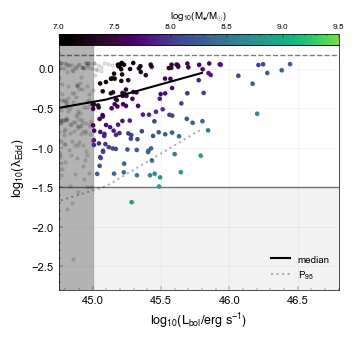

In [9]:
xlimits = [44.75, 46.8] # Msun
ylimits = np.array([-2.8, 0.299])

fig = plt.figure(figsize = (3.5, 3.5))

left  = 0.15
height = 0.7
bottom = 0.15
width = 0.8
hwidth = 0.2

ax = fig.add_axes((left, bottom, width, height))
cax = fig.add_axes([left, bottom+height, width, 0.03])

norm = Normalize(vmin=7., vmax=9.5)
cmap = cmr.lavender
n = norm

ax.axhline(np.log10(1/flares.h), c='k', lw=1, alpha=0.5, ls='--')
ax.axhline(-1.5, c='k', lw=1, alpha=0.5)
ax.fill_between(xlimits,[-10,-10],[-1.5, -1.5], color='k', alpha=0.05)

ax.fill_between([42., 45.],[-10,-10],[0.5, 0.5], hatch='///', color='0.7')

ax.scatter(np.log10(bolometric_luminosity.to('erg/s').value),
           np.log10(eddington_ratio),
           s=5,
           zorder=1,
           c='k',
           alpha=0.1)

ax.scatter(np.log10(bolometric_luminosity.to('erg/s').value[conservative_selection]),
           np.log10(eddington_ratio[conservative_selection]),
           s=5,
           zorder=2,
           c=cmap(norm(np.log10(blackhole_mass.to('Msun').value[conservative_selection]))))

# plot median relation
bins = np.arange(43., 47., 0.7)
median, bin_edges, N = binned_statistic(
    np.log10(bolometric_luminosity.to('erg/s').value), 
    np.log10(eddington_ratio), 
    bins=bins, 
    statistic='median')

ax.plot(bins[:-1], median, c='k', ls='-', label='median')


# plot 99th percentil relation
bins = np.arange(43., 47., 0.7)
median, bin_edges, N = binned_statistic(
    np.log10(bolometric_luminosity.to('erg/s').value), 
    np.log10(eddington_ratio), 
    bins=bins, 
    statistic=lambda x: np.percentile(x, 0.95))

ax.plot(bins[:-1], median, c='k', ls=':', alpha=0.3, label='$P_{95}$')

# # accretion weighted
# median = binned_weighted_quantile(np.log10(bolometric_luminosity.to('erg/s').value), 
#                                   np.log10(eddington_ratio), 
#                                   blackhole_accretion_rate.value, 
#                                   mass_bins, 
#                                   [0.5])

# ax.plot(mass_bins[:-1], median, c='k', ls='-')

ax.set_xlim(xlimits)
ax.set_ylim(ylimits)
# ax.set_yscale('log')

ax.set_xlabel(r'$\rm log_{10}(L_{bol}/erg\ s^{-1})$')
ax.set_ylabel(r'$\rm log_{10}(\lambda_{\rm Edd})$')

ax.legend(fontsize=7)

# add colourbar
cmapper = cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cmapper, cax=cax, orientation='horizontal')
cax.xaxis.tick_top()
cax.xaxis.set_label_position('top')
cax.set_xlabel(r'$\rm log_{10}(M_{\bullet}/M_{\odot})$', fontsize=7)
cax.tick_params(axis='x', labelsize=6)


filename = f'figures/bolometric_luminosity-eddington.pdf'
print(filename)

fig.savefig(filename)
plt.show()
fig.clf()